# Deep Learning - Time Series Prediction

## Objective of this Notebook

1. Show how to use LSTM for time series prediction with Keras

2. Calculate confidence bands for predictions with LSTMs

3. Do some simple feature engineering

In [1]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 15, 6

# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep Learing
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras import backend as K


from python_code.data_preparation import create_tensors
from python_code.data_preparation import load_series

Using TensorFlow backend.


## Task Description

### Data Parameters

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. In this example, we just have a look at one series, namely with id `MAC000002`. We have:

- Number of series: 1
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)

In [52]:
data_path = 'prepared_data/london_smart_meter/'
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

### Experiment Parameters

We will fit a model for one day ahead energy prediction by using todays energy consumption. This is a little bit an artificial scnenario, but it is easy to modify this code for other scenarios. We will use 90 days for training (10% for validation) and 30 days for prediction by a rolling window approach.

In [53]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')

Split the data into train and test set.

In [54]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

### Prepare Data for LSTM

Let us start with a single series. In the next steps we have to generate the 3 dimensional arrays ([samples, n_in, n_features]) that we need for the LSTM. But before we do this, we have to normalize data on the training set. 

In [55]:
scaler = MinMaxScaler(feature_range=(0, 1))
# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])

In [56]:
df_train.describe()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.00000,2160.000000,2160.000000
mean,11.020843,220.766204,7.453370,4.644431,1012.210560,5.587375,4.18312,0.828111,0.090101
std,3.019582,72.745156,2.793201,2.971788,14.695202,3.614686,2.34301,0.086937,0.118516
min,0.270000,0.000000,-1.270000,-3.300000,976.000000,-4.810000,0.11000,0.550000,0.000000
25%,9.975000,191.750000,5.547500,2.270000,1000.337500,3.037500,2.50000,0.770000,0.005903
50%,11.970000,223.000000,7.565000,4.560000,1012.695000,5.190000,3.80000,0.850000,0.052302
75%,12.730000,258.250000,9.315000,6.660000,1024.780000,7.702500,5.34000,0.890000,0.140024
max,16.090000,359.000000,15.080000,13.180000,1040.130000,15.080000,14.56000,1.000000,1.000000


Now, we can calculate the training tensors.

In [57]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [58]:
train_X.shape

(89, 24, 9)

### Define & Train LSTM Network

Let us try a simple 3 layer LSTM network.  

In [59]:
def keras_model(rate):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(h_params['n_out']))
    return model

In [60]:
model = keras_model(0.2)
model.compile(loss='mae', optimizer = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_split = .1, verbose=2, shuffle=True)

Train on 80 samples, validate on 9 samples
Epoch 1/50
 - 3s - loss: 0.4910 - val_loss: 0.1921
Epoch 2/50
 - 3s - loss: 0.3358 - val_loss: 0.1985
Epoch 3/50
 - 3s - loss: 0.2802 - val_loss: 0.1648
Epoch 4/50
 - 3s - loss: 0.2345 - val_loss: 0.1369
Epoch 5/50
 - 3s - loss: 0.2014 - val_loss: 0.1274
Epoch 6/50
 - 3s - loss: 0.1763 - val_loss: 0.1083
Epoch 7/50
 - 3s - loss: 0.1647 - val_loss: 0.0830
Epoch 8/50
 - 3s - loss: 0.1464 - val_loss: 0.0937
Epoch 9/50
 - 3s - loss: 0.1341 - val_loss: 0.0771
Epoch 10/50
 - 3s - loss: 0.1250 - val_loss: 0.0854
Epoch 11/50
 - 3s - loss: 0.1175 - val_loss: 0.0852
Epoch 12/50
 - 3s - loss: 0.1155 - val_loss: 0.0867
Epoch 13/50
 - 3s - loss: 0.1079 - val_loss: 0.0982
Epoch 14/50
 - 3s - loss: 0.1032 - val_loss: 0.0772
Epoch 15/50
 - 3s - loss: 0.0965 - val_loss: 0.0708
Epoch 16/50
 - 3s - loss: 0.0919 - val_loss: 0.0702
Epoch 17/50
 - 3s - loss: 0.0903 - val_loss: 0.0742
Epoch 18/50
 - 3s - loss: 0.0860 - val_loss: 0.0758
Epoch 19/50
 - 3s - loss: 0.08

Summarise the training and validation loss

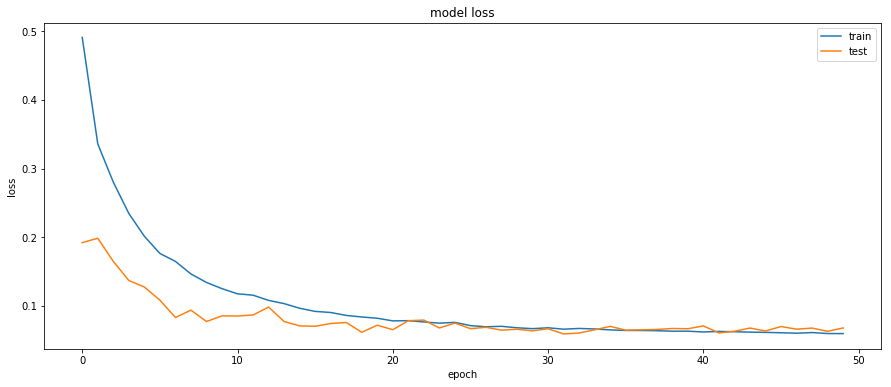

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Perform prediction

In [62]:
test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [63]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

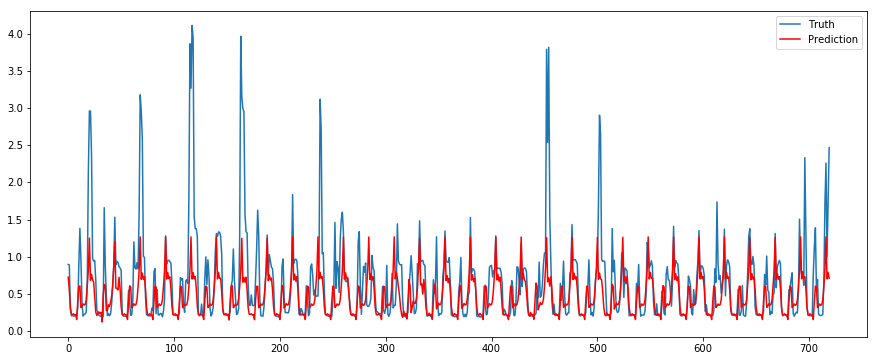

In [64]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [65]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 36.40 SMAPE: 19.06


This can be done better. But let us next try to calculate confidence bands.

## Confidence Bands

In [66]:
def predict_with_uncertainty(model, test_X, n_iter=100):
    f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1, 24,))
    for iter in range(n_iter):
        all_pred[iter] = f([test_X, 1])
    ts_std = all_pred.std(axis = 0)
    avg_pred = all_pred.mean(axis=0)
    return all_pred, avg_pred, ts_std

Let us predict the first 10 days with confidence bands.

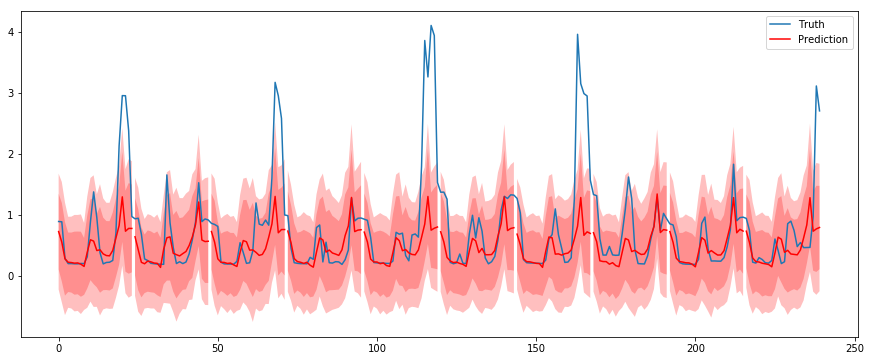

In [67]:
n = 10
plt.plot(y[:(n * 24)])
# n = len(test_X)
for i in range(0, n):
    _, avg_pred, ts_std = predict_with_uncertainty(model, test_X[i].reshape(1, 24, test_X[i].shape[1]), 100)
    yHat = scaler.inverse_transform(avg_pred).reshape(avg_pred.shape[0] * avg_pred.shape[1])
    YHat_SD = scaler.inverse_transform(ts_std).reshape(ts_std.shape[0] * ts_std.shape[1])
    y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])
    plt.plot(range(i * 24, (i + 1) * 24), yHat, color='red')
    # plots the uncertainty to the degree of half a standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 1.96 * YHat_SD, 
                     yHat - 1.96 * YHat_SD, 
                     facecolor='red', alpha=0.25)

    # plots the uncertainty to the degree of a full standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 3 * YHat_SD, 
                     yHat - 3 * YHat_SD, 
                     facecolor='red', alpha=0.25)
    plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

## More Features

In this section we add additional to the time related features some weather features. We **assume** in this experiment that the weather features in `X_test` are weather forecasts. This may be not practicable for longer prediction windows.

In [75]:
data_path = 'prepared_data/london_smart_meter/'
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

In [76]:
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')
df_train = df[df.index <= date_train].drop('id', axis = 1)
df_test = df[df.index > date_train].drop('id', axis = 1)
df_train.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
date,,,,,,,,,
2013-10-30 00:00:00+01:00,14.31,244,6.86,4.61,1017.98,4.55,3.29,0.86,0.457
2013-10-30 01:00:00+01:00,14.31,238,6.10,4.09,1018.38,3.86,2.95,0.87,0.414
2013-10-30 02:00:00+01:00,13.45,247,5.94,4.17,1018.89,3.54,3.14,0.88,0.408
2013-10-30 03:00:00+01:00,13.23,249,5.54,3.92,1019.25,3.13,3.02,0.89,0.352
2013-10-30 04:00:00+01:00,14.31,242,5.06,3.28,1019.57,2.78,2.74,0.88,0.250


In [77]:
df_train['weekday'] = df_train.index.weekday
df_train['hour'] = df_train.index.hour
df_test['weekday'] = df_test.index.weekday
df_test['hour'] = df_test.index.hour

In [78]:
features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
for f in features:
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_train[[f]])
    df_train[[f]] = scaler.transform(df_train[[f]])
    df_test[[f]] = scaler.transform(df_test[[f]])
    
scaler = MinMaxScaler(feature_range=(0, 1))
# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])

In [79]:
df_train.describe()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy,weekday,hour
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000
mean,0.679573,0.614948,0.533539,0.482065,0.564643,0.522744,0.281877,0.618025,0.090101,0.503704,0.500000
std,0.190871,0.202633,0.170838,0.180327,0.229147,0.181734,0.162146,0.193193,0.118516,0.333390,0.301034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.613464,0.534123,0.416972,0.337985,0.379503,0.394545,0.165398,0.488889,0.005903,0.166667,0.250000
50%,0.739570,0.621170,0.540367,0.476942,0.572197,0.502765,0.255363,0.666667,0.052302,0.500000,0.500000
75%,0.787611,0.719359,0.647401,0.604369,0.760642,0.629085,0.361938,0.755556,0.140024,0.833333,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [80]:
train_X, train_y = create_tensors(df_train, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [88]:
model = keras_model(0.2)
model.compile(loss='mae', optimizer = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_split = .1, verbose=2, shuffle=True)

Train on 80 samples, validate on 9 samples
Epoch 1/50
 - 3s - loss: 0.1033 - val_loss: 0.0788
Epoch 2/50
 - 3s - loss: 0.0802 - val_loss: 0.0705
Epoch 3/50
 - 3s - loss: 0.0709 - val_loss: 0.0663
Epoch 4/50
 - 3s - loss: 0.0670 - val_loss: 0.0600
Epoch 5/50
 - 3s - loss: 0.0628 - val_loss: 0.0636
Epoch 6/50
 - 3s - loss: 0.0614 - val_loss: 0.0656
Epoch 7/50
 - 3s - loss: 0.0593 - val_loss: 0.0675
Epoch 8/50
 - 3s - loss: 0.0574 - val_loss: 0.0584
Epoch 9/50
 - 3s - loss: 0.0566 - val_loss: 0.0587
Epoch 10/50
 - 3s - loss: 0.0570 - val_loss: 0.0553
Epoch 11/50
 - 3s - loss: 0.0561 - val_loss: 0.0592
Epoch 12/50
 - 3s - loss: 0.0544 - val_loss: 0.0586
Epoch 13/50
 - 3s - loss: 0.0548 - val_loss: 0.0581
Epoch 14/50
 - 3s - loss: 0.0551 - val_loss: 0.0605
Epoch 15/50
 - 3s - loss: 0.0552 - val_loss: 0.0561
Epoch 16/50
 - 3s - loss: 0.0537 - val_loss: 0.0578
Epoch 17/50
 - 3s - loss: 0.0540 - val_loss: 0.0558
Epoch 18/50
 - 3s - loss: 0.0535 - val_loss: 0.0592
Epoch 19/50
 - 3s - loss: 0.05

In [89]:
test_X, test_y = create_tensors(df_test, h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [90]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

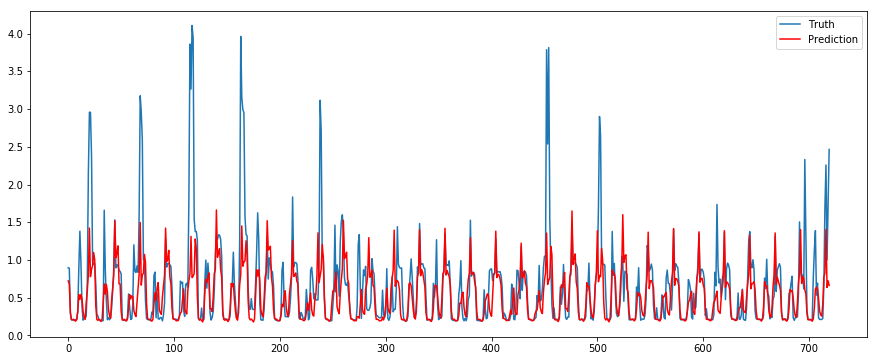

In [91]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [92]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 32.72 SMAPE: 16.33


We got an improvement on about 3% for this series by using additional features.